# Signal Creation Pipeline

In [199]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from modules.signals import plot_realization, get_sentiment_score, compute_key_metrics, get_relative_strength_index, get_moving_average_crossover
from modules.data_utils import load_reddit_data, load_bitcoin_data
from modules.data_cleaning import preprocess_data
from modules.sentiment_analysis import get_roberta_checkpoint
from modules.btc_price_data_processing import add_performance_metrics
from modules.utils import set_pandas_display_options
set_pandas_display_options()

## Load and clean data

In [118]:
df = load_reddit_data()

## Sentiment Analysis

In [119]:
# get checkpoint
sentiment_roberta = get_roberta_checkpoint()

# merge sentiment
df = pd.merge(df, sentiment_roberta, how="left", on="submission")

## Relevance filtering

In [120]:
# LDA filter
topic_keywords = pd.read_csv("topic_keywords.csv")
trading_keywords = topic_keywords.loc[topic_keywords["Topic"]=="Topic 2", "Keyword"].values

com_filter = (df["num_comments"] > 100)
lda_filter = df["selftext"].str.lower().str.contains("|".join(trading_keywords))
print(df.shape)
df_lda = df.loc[lda_filter].copy() # filter on LDA topics
print(df_lda.shape)

(15582, 28)
(11048, 28)


## Sentiment Signal

In [167]:
df_raw = df_lda.copy()

In [168]:
df = df_raw.copy()

In [169]:
from modules.signals import get_sentiment_score
lag = "1h"
df = get_sentiment_score(df, lag, exponential_decay=True, num_comments_weighting=False, alpha_name="alpha_sentiment")

## Merge baseline strategies

In [170]:
from modules.signals import get_relative_strength_index
df_rsi = get_relative_strength_index(lower_cutoff=df["datetime"].min(), upper_cutoff=df["datetime"].max())

In [171]:
from modules.signals import get_moving_average_crossover
df_maco = get_moving_average_crossover(lower_cutoff=df["datetime"].min(), upper_cutoff=df["datetime"].max())

In [172]:
df = pd.merge_asof(df_rsi[["rsi_signal"]], df, on='datetime', direction='backward')
df = pd.merge_asof(df_maco[["maco_signal"]], df, on='datetime', direction='backward')

# Price prediction

In [221]:
plot_df = df.copy()
plot_df = add_performance_metrics(plot_df, [1])

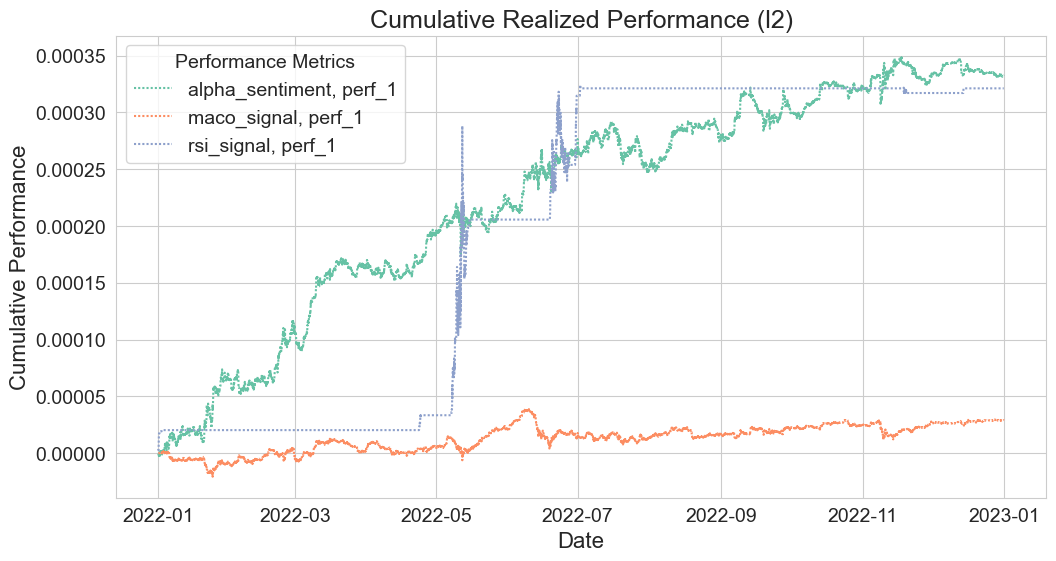

In [223]:
# no num_comments, Y exponential smoothing, Y LDA filtering
from modules.signals import plot_realization
perfs = [c for c in plot_df.columns if "perf" in c]
signals = ["alpha_sentiment", "maco_signal", "rsi_signal"]
plot_realization(plot_df, signals, perfs, "l2", threshold=0.9)

In [ ]:
for signal in signals:
    print("Metrics for", signal)
    print(compute_key_metrics(plot_df, signal, perfs))

Metrics for alpha_sentiment
{'sharpe': [2.733461981947082], 'bias': [-0.0001917852541314414], 'beta': [-0.00022225284182712774]}
Metrics for maco_signal
{'sharpe': [0.6759602110707192], 'bias': [-6.576270720388111e-05], 'beta': [-6.661798639577427e-05]}
Metrics for rsi_signal
{'sharpe': [1.6245637925919008], 'bias': [-0.00018250775067997255], 'beta': [-0.0008795466183439615]}


## Experiments

-0.0002243827342087423
-6.661798639577427e-05
-0.0008795466183439615


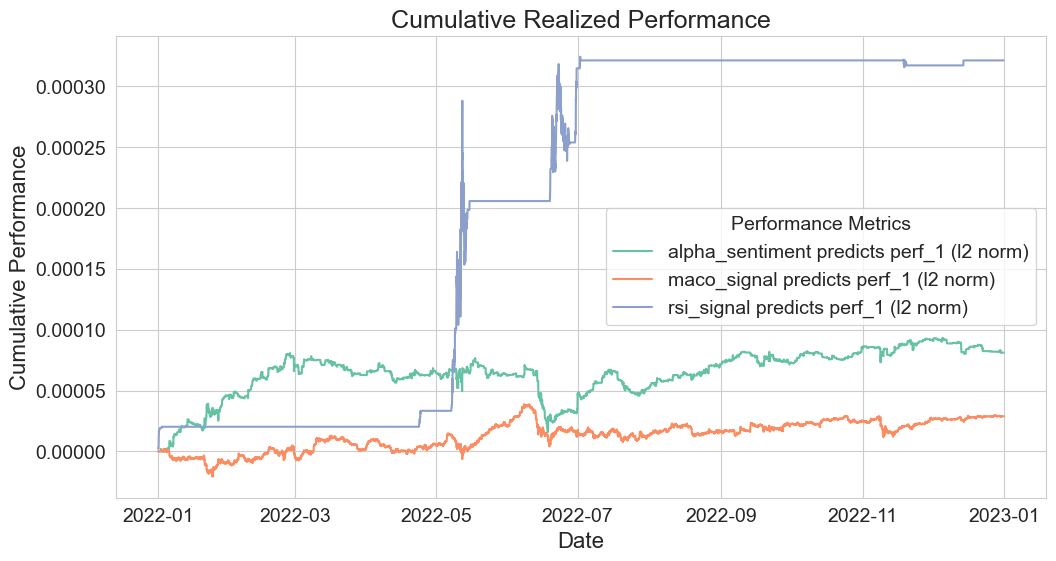

In [136]:
# no num_comments, no exponential smoothing, no LDA filtering
from modules.signals import plot_realization
perfs = [c for c in plot_df.columns if "perf" in c]
signals = ["alpha_sentiment", "maco_signal", "rsi_signal"]
plot_realization(plot_df, signals, perfs, "l2", threshold=0.9)

-0.00036892604202118276
-6.661798639577427e-05
-0.0008795466183439615


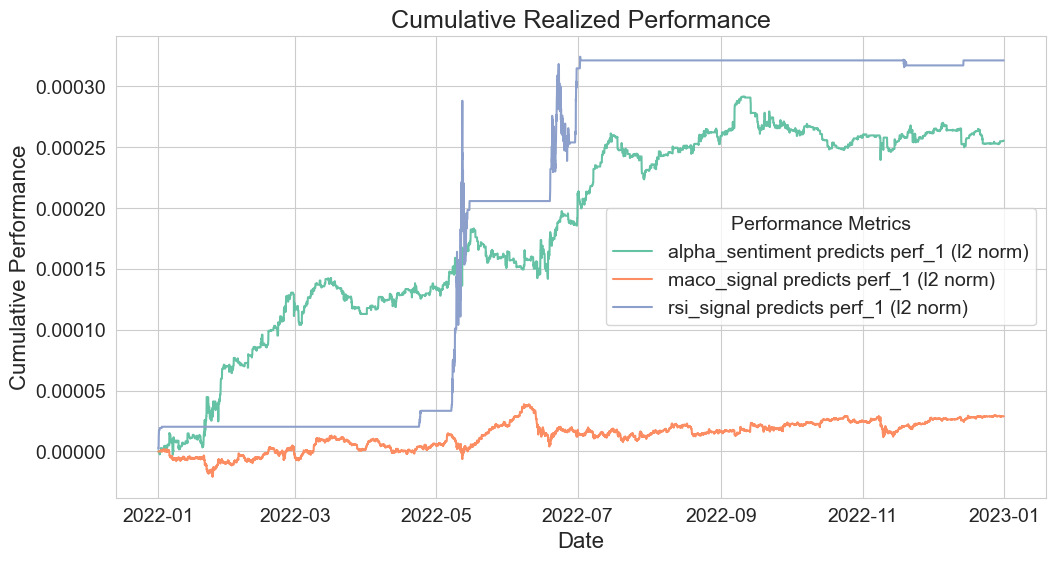

In [ ]:
# no num_comments, no exponential smoothing, Y LDA filtering
from modules.signals import plot_realization
perfs = [c for c in plot_df.columns if "perf" in c]
signals = ["alpha_sentiment", "maco_signal", "rsi_signal"]
plot_realization(plot_df, signals, perfs, "l2", threshold=0.9)

-0.00034204943632640673
-6.661798639577427e-05
-0.0008795466183439615


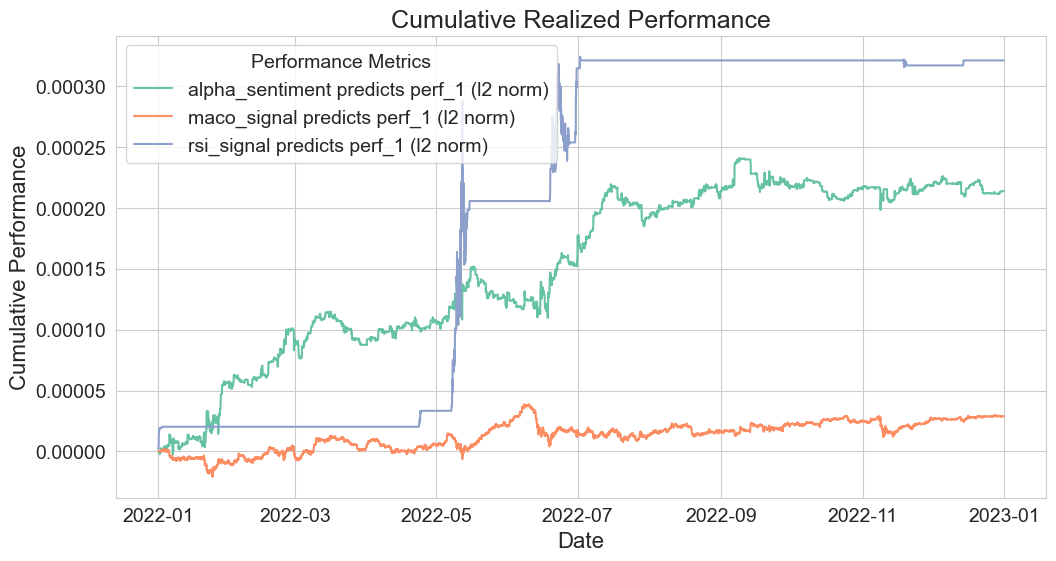

In [151]:
# Y num_comments, no exponential smoothing, Y LDA filtering
from modules.signals import plot_realization
perfs = [c for c in plot_df.columns if "perf" in c]
signals = ["alpha_sentiment", "maco_signal", "rsi_signal"]
plot_realization(plot_df, signals, perfs, "l2", threshold=0.9)

-0.00022225284182712774
-6.661798639577427e-05
-0.0008795466183439615


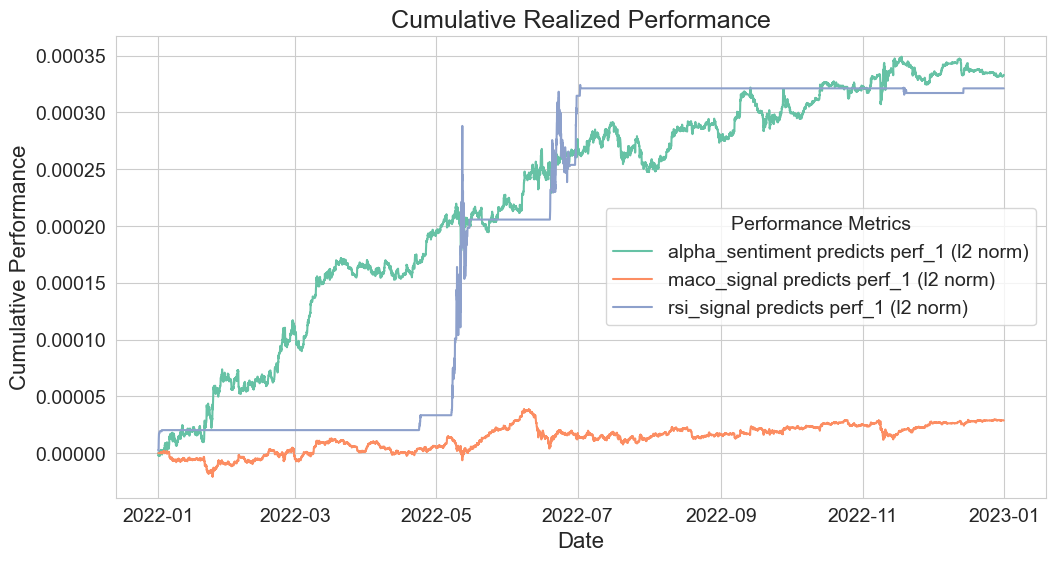

In [174]:
# no num_comments, Y exponential smoothing, Y LDA filtering
from modules.signals import plot_realization
perfs = [c for c in plot_df.columns if "perf" in c]
signals = ["alpha_sentiment", "maco_signal", "rsi_signal"]
plot_realization(plot_df, signals, perfs, "l2", threshold=0.9)

In [52]:
for signal in signals:
    print("Metrics for", signal)
    print(compute_key_metrics(plot_df, signal, perfs))

Metrics for alpha_sentiment
{'sharpe': [2.733461981947082], 'bias': [-0.0001917852541314414], 'beta': [-0.00022225284182712774]}
Metrics for maco_signal
{'sharpe': [0.6759602110707192], 'bias': [-6.576270720388111e-05], 'beta': [-6.661798639577427e-05]}
Metrics for rsi_signal
{'sharpe': [1.6245637925919008], 'bias': [-0.00018250775067997255], 'beta': [-0.0008795466183439615]}


Why does `num_comments` not improve the signal?

In [ ]:
t = plot_df.copy()
t.index = t["datetime"]

In [180]:
alpha = "alpha_sentiment"
perf = "perf_1"

In [181]:
beta = t[alpha].cov(t[perf]) / t[alpha].var()
t["real"] =  t[alpha] * t[perf] * beta

Text(0, 0.5, 'Number of comments')

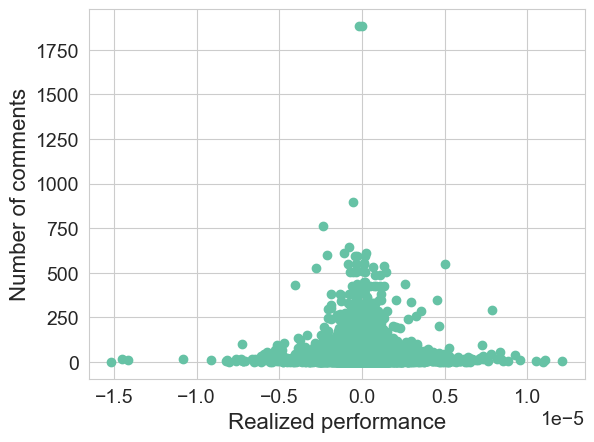

In [184]:
plt.scatter(t["real"], t["num_comments"])
plt.xlabel("Realized performance")
plt.ylabel("Number of comments")

Is the beta consistent over time? Plot beta_t for all t

In [188]:
df.columns

Index(['datetime', 'maco_signal', 'rsi_signal', 'submission', 'subreddit',
       'author', 'created', 'retrieved', 'edited', 'pinned', 'archived',
       'locked', 'removed', 'deleted', 'is_self', 'is_video',
       'is_original_content', 'title', 'link_flair_text', 'upvote_ratio',
       'score', 'gilded', 'total_awards_received', 'num_comments',
       'num_crossposts', 'selftext', 'thumbnail', 'shortlink',
       'positive_score', 'negative_score', 'rolling_positive_score',
       'rolling_negative_score', 'alpha_sentiment'],
      dtype='object')

In [189]:
ts = []
betas = []

for t in plot_df["datetime"]:
    ts.append(t)

    df_sub = plot_df.loc[df["datetime"]<=t]
    
    beta = df_sub[alpha].cov(df_sub[perf]) / df_sub[alpha].var()
    # df["real"] =  df_sub[alpha] * df_sub[perf] * beta
    betas.append(beta) 

c:\Users\jakob\miniconda3\envs\ds\Lib\site-packages\pandas\core\nanops.py:1675: RuntimeWarning: Degrees of freedom <= 0 for slice
  return np.cov(a, b, ddof=ddof)[0, 1]
c:\Users\jakob\miniconda3\envs\ds\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\jakob\miniconda3\envs\ds\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\jakob\AppData\Local\Temp\ipykernel_16924\932944497.py:9: RuntimeWarning: invalid value encountered in scalar divide
  beta = df_sub[alpha].cov(df_sub[perf]) / df_sub[alpha].var()


In [190]:
assert len(ts) == len(betas)

Text(0.5, 1.0, 'Is $\\beta$ stable over time?')

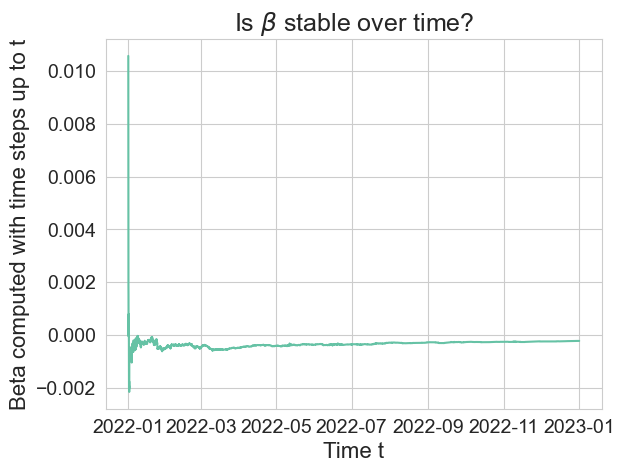

In [194]:
plt.plot(ts, betas)
plt.xlabel("Time t")
plt.ylabel("Beta computed with time steps up to t")
plt.title(r"Is $\beta$ stable over time?")